# Monte Carlo Simulation for Pricing Asian Options

In [730]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import sympy as sp

There are going to be 3 parts,
- Part 1: Analyzing the random asset paths generated by the 3 schemes
- Part 2: Analyzing the relationship between option price and the number of simulations
- Part 3: Sensitivity of option price to the price of the underlying, the volatility, interest rate, and time-to-expiry

## Part 1 (Analyzing the random asset paths generated by the 3 schemes)

Ideally, we would use the closed-form solution when generating a random walk. However, the closed-form solution may not always be available. Hence, we would need to use an approximation of the closed-form solution, such as the Milstein scheme and the Euler-Maruyama scheme.

Here I will show you 3 ways to generate Geometric Brownian Motion GBM): Milstein scheme, Euler-Maruyama (EM) scheme, and the closed form solution. The equations below shows how to generate GBM using these methods,
- EM scheme: $S_{t+\delta t} = S_{t} + r S_t \delta t + \sigma S_{t} \phi \sqrt{\delta t}$
- Milstein scheme: $S_{t+\delta t} = S_{t} + r S_t \delta t + \sigma S_{t} \phi \sqrt{\delta t} + \frac{1}{2} S_{t} \sigma^2 (\phi^2 - 1) \delta t$
- Closed-form: $S_{t+\delta t} = S_{t} e^{((r - \frac{1}{2} \sigma^2) \delta t + \sigma \phi \sqrt{\delta t})}$

Where $\phi$ is a random variable that follows the standard normal distribution, i.e. N(0,1).

The Milstein and EM are an approximation to the closed-form solution, in which the Milstein scheme is more accurate than Euler-Maruyama (EM) scheme because the Milstein scheme is just the EM scheme but it also includes the Milstein “correction” term, i.e. $0.5*\sigma^2*(\phi - 1)*\delta t$. The error of Milstein and EM scheme is $O(\delta t)$ and $O(\delta t^{0.5})$, respectively.

In [994]:
# define path simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims, sim_type):
    NTS = timesteps
    T = horizon
    dt = T / NTS
    
    np.random.seed(123)
    
    # create an empty array
    arr = np.zeros((1+NTS,n_sims))
    
    # simulate 'n' asset price path with 't' timesteps
    for i in range(0,n_sims):
        phi = np.random.normal(size=NTS)
        s = s0
        s_em_big = [s0]
        
        if sim_type == "euler":
            for j in range(1,NTS+1):
                s += mu * s * (dt) + sigma*s*sum(phi[(j-1):j])*np.sqrt(dt)
                s_em_big.append(s)
        elif sim_type == "milstein":
            for j in range(1,int(NTS)+1):
                s += mu * s * (dt) + sigma*s*sum(phi[(j-1):j])*np.sqrt(dt) + s*0.5*sigma**2*(sum(phi[(j-1):j])**2 - 1)*dt
                s_em_big.append(s)
        elif sim_type == "closed":
            for j in range(1,NTS+1):
                s = s*(np.e**((mu-0.5*sigma**2)*dt + sigma*phi[j-1]*np.sqrt(dt)))
                s_em_big.append(s)
        else:
            print("INVALID SIMULATION TYPE")
        
        #insert the list into the array
        arr[:,i] = s_em_big
    
    time_points = np.arange(0,T+dt,dt)
    df = pd.DataFrame(arr)
    df.index = time_points
    
    return df

#### Initial simulation
Now I am going to simulate an asset path for each of the 3 schemes. The following shows the list of paramaters used in the simulation:
- Initial stock price = $100
- Drift = 0.05
- Volatility = 0.2
- Horizon = 1
- Number of time steps (NTS) = 100

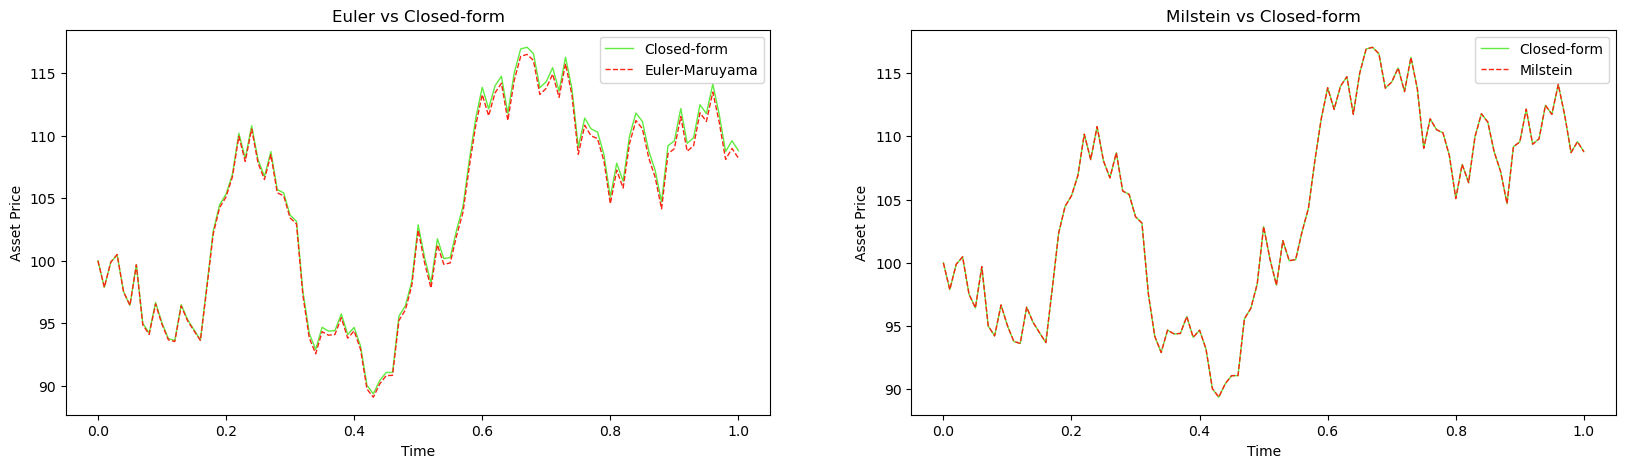

In [995]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.2,1,100,1

# Euler GBM
price_path_euler_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")

# Milstein GBM
price_path_milstein_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")

# Closed-form GBM
price_path_closed_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Generate plots
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(price_path_closed_intial, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[0].plot(price_path_euler_intial, label="Euler-Maruyama", color="#fc2412",ls='--', linewidth = '1')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Asset Price")
ax[0].set_title("Euler vs Closed-form")
ax[0].legend()

ax[1].plot(price_path_closed_intial, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[1].plot(price_path_milstein_intial, label="Milstein", color="#fc2412",ls='--',linewidth = '1')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Asset Price")
ax[1].set_title("Milstein vs Closed-form")
ax[1].legend()

plt.show()

From the plots above, we see that the Milstein scheme can more accurately approximate/follow the asset path generated using the closed-form solution, compared to the EM scheme.

To be able to more clearly see the accuracy of these approximations, we are now going to calculate the sum of squares error of the EM and Milstein scheme using the following formula:

$$Squares Error = \sum^n_{i=1}(S_{T,i}(Closed Form) - S_{T,i}(Approximation))^2$$
Where n is the number of simulations; $S_{T,i}$ is the final asset price of the ith simulation.

In [1005]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.2,1,100,1000
# Closed-form GBM
price_path_closed_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Euler GBM
price_path_euler_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")
error_euler = sum((price_path_closed_intial.iloc[-1,:] - price_path_euler_intial.iloc[-1,:])**2)
print("The sum of squares error of the EM scheme is", round(error_euler,3))

# Milstein GBM
price_path_milstein_intial = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")
error_milstein = sum((price_path_closed_intial.iloc[-1,:] - price_path_milstein_intial.iloc[-1,:])**2)
print("The sum of squares error of the Milstein scheme is", round(error_milstein,3))

The sum of squares error of the EM scheme is 91.721
The sum of squares error of the Milstein scheme is 0.158


The above shows the sum of squares error from 1000 asset path simulations. It is very clear to see that the sum of squares error of the Milstein scheme is much smaller than the EM scheme, which again shows that the Milstein scheme is a better approximator of the closed-form solution.

#### The impact of the change in time-step size
Now I am going to show the impact of the time-step size on the accuracy of the approximation of the EM and Milstein scheme. Below we show the GBM with the number of time steps that is decreased to 10 (hence increasing the size of the time step).

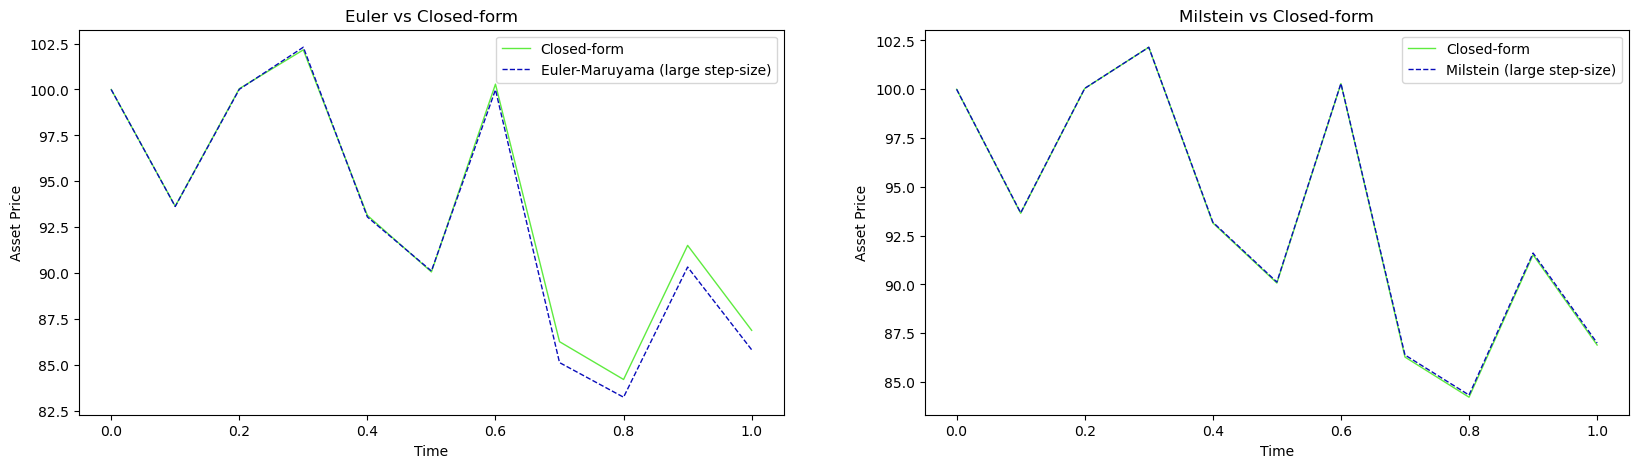

In [1000]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.2,1,10,1

# Closed-form GBM
price_path_closed = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Euler GBM
    # (large step)
price_path_euler_large = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")
    
# Milstein GBM
    # (large step)
price_path_milstein_large = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")

# Generate plots
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(price_path_closed, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[0].plot(price_path_euler_large, label="Euler-Maruyama (large step-size)", color="#090cba",ls='--', linewidth = '1')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Asset Price")
ax[0].set_title("Euler vs Closed-form")
ax[0].legend()

ax[1].plot(price_path_closed, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[1].plot(price_path_milstein_large, label="Milstein (large step-size)", color="#090cba",ls='--',linewidth = '1')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Asset Price")
ax[1].set_title("Milstein vs Closed-form")
ax[1].legend()

plt.show()

The interesting thing to note here is that, by increasing the size of the time-step, both EM scheme and Milstein scheme are less able to approximate the closed-form solution. To see this more clearly, we are going to compute the sum of the squares error:

In [1004]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.2,1,10,1000

# Closed-form GBM
price_path_closed = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Euler GBM
    # (large step)
price_path_euler_large = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")
error_euler_large = sum((price_path_closed.iloc[-1,:] - price_path_euler_large.iloc[-1,:])**2)
print("The sum of squares error of the EM scheme with large time-step size is", round(error_euler_large,3))

# Milstein GBM
    # (large step)
price_path_milstein_large = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")
error_milstein_large = sum((price_path_closed.iloc[-1,:] - price_path_milstein_large.iloc[-1,:])**2)
print("The sum of squares error of the Milstein scheme with large time-step size is", round(error_milstein_large,3))

The sum of squares error of the EM scheme with large time-step size is 863.393
The sum of squares error of the Milstein scheme with large time-step size is 13.58


Recall that the sum of squares error for the simulation with a small time-step size was 91.721 and 0.158 for the EM and Milstein scheme, respectively. And so if we compare the sum of squares error between the simulation with a large time-step and small time-step size, we can see that the sum of squares error increases as the time-step size increases (note that in both of these cases, the sum of squares error was calculated from the result of 1000 simulations). Hence, we need to minimize the size of the time-step size in order to reduce the approximation error.

#### Increasing the volatility
Now I am going to show the impact of the volatility on the accuracy of the approximation of EM and Milstein scheme. Below we show the GBM with a constant volatility that is increased to 0.8.

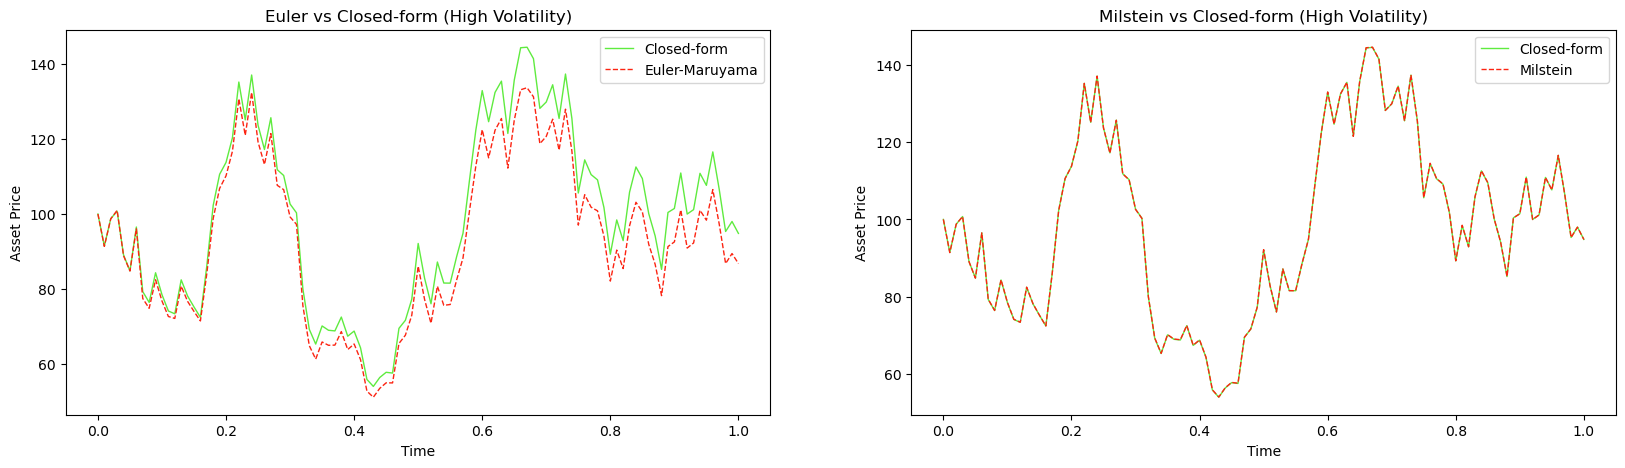

In [997]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.8,1,100,1

# Euler GBM
price_path_euler_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")

# Milstein GBM
price_path_milstein_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")

# Closed-form GBM
price_path_closed_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Generate plots
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(price_path_closed_highvol, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[0].plot(price_path_euler_highvol, label="Euler-Maruyama", color="#fc2412",ls='--', linewidth = '1')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Asset Price")
ax[0].set_title("Euler vs Closed-form (High Volatility)")
ax[0].legend()

ax[1].plot(price_path_closed_highvol, label="Closed-form", color="#5feb3f",ls='-',linewidth = '1')
ax[1].plot(price_path_milstein_highvol, label="Milstein", color="#fc2412",ls='--',linewidth = '1')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Asset Price")
ax[1].set_title("Milstein vs Closed-form (High Volatility)")
ax[1].legend()

plt.show()

Comparing this plot with our initial plot, we observe that, as we increase volatility, the GBM generated using the EM and Milstein scheme are more farther apart from the GBM generated using the closed-form solution (though it's not very visible in the Milstein scheme). So we can conclude that the approximation of the closed-form by EM and Milstein scheme are worsen as we increase volatility.

Just like what we did before, we are now going to calculate the sum of the squared error.

In [1008]:
s0, mu, sigma, horizon, timesteps, n_sims = 100,0.05,0.8,1,100,1000
# Closed-form GBM
price_path_closed_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="closed")

# Euler GBM
price_path_euler_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="euler")
error_euler_highvol = sum((price_path_closed_highvol.iloc[-1,:] - price_path_euler_highvol.iloc[-1,:])**2)
print("The sum of squares error of the EM scheme in a high volatility environemnt is", round(error_euler_highvol,3))

# Milstein GBM
price_path_milstein_highvol = simulate_path(s0, mu, sigma, horizon, timesteps,
                                              n_sims, sim_type="milstein")
error_milstein_highvol = sum((price_path_closed_highvol.iloc[-1,:] - price_path_milstein_highvol.iloc[-1,:])**2)
print("The sum of squares error of the Milstein scheme in a high volatility environemnt is", round(error_milstein_highvol,3))

The sum of squares error of the EM scheme in a high volatility environemnt is 49151.223
The sum of squares error of the Milstein scheme in a high volatility environemnt is 117.349


Recall that the sum of squares error in the low volatility environment was 91.721 and 0.158 for the EM and Milstein scheme, respectively. We can clearly see that the sum of squares error in the low volatility environment is smaller than in the high volatility environment (note that in both cases, the sum of squares error was calculated from the result of 1000 simulations). And so we can conclude that the accuracy of approximation of the closed-form by EM and Milstein scheme are both worsen as we increase volatility.

## Part 2 (Analyzing the relationship between option price and the number of simulations)

Various types of asian options will be used to analyze the relationship between the option price and number of simulations. This includes asian options with,
- fixed ($100) or floating strike price;
- discrete or continuous sampling;
- arithmetic or geometric averaging

In [1054]:
# define the function that calculates the value of an Asian option
def monte_carlo_asian(s0, mu, sigma, horizon, timesteps, n_sims, sim_type, option_type, strike_type, sampling_type, average_type, strike=None, seed=1):
    '''
    sim_type -> milstein, euler, or closed
    option_type -> call or put
    strike_type -> fixed or floating
    sampling_type -> discrete or continuous
    average_type -> arithmetic or geometric
    '''

    # read parameters
    S0 = s0                 # initial spot price
    r = mu                  # mu = r in risk neutral framework
    T = horizon             # time horizon
    NTS = timesteps           # number of time steps
    n = n_sims              # number of simulation
    sigma = sigma           # standard deviation / volatility
    E = strike              # option strike price
    
    # define dt
    dt = T/NTS                # length of time interval

    # set the random seed for reproducibility
    np.random.seed(seed)
    
    # simulate 'n' asset price path with 't' timesteps
    arr = np.zeros((NTS+1,n))
    arr[0,:] = S0    #selects the first row of the array
    
    # type of GBM
    if sim_type == "euler":
        for i in range(0, NTS):
            w = np.random.normal(size=n)
            arr[i+1,:] = arr[i,:] * (1 + r*dt + sigma*np.sqrt(dt)*w)
    elif sim_type == "milstein":
        for i in range(0, NTS):
            w = np.random.normal(size=n)
            arr[i+1,:] = arr[i,:] * (1 + r*dt + sigma*np.sqrt(dt)*w + 0.5*(sigma**2)*(w**2-1)*dt)
    elif sim_type == "closed":
        for i in range(0, NTS):
            w = np.random.normal(size=n)
            arr[i+1,:] = arr[i,:]*np.e**((r-0.5*sigma**2)*dt + sigma*w*np.sqrt(dt))
    else:
        print("INVALID SIM_TYPE!")
    
    # average calculation
    # assuming discrete sampling is done once every month, with the last sample taken on expiry
    number_of_samples = int(T/(1/12))
    if sampling_type == "discrete":
        interval = int(NTS/number_of_samples) # time interval between sampling
        total = np.zeros((1,n_sims))
        if average_type == "arithmetic":
            for x in range(number_of_samples):
                sampling_time = interval * x
                total = total + arr[-1-sampling_time,:]
            avg = total / number_of_samples
        elif average_type == "geometric":
            for x in range(number_of_samples):
                sampling_time = interval * x
                total = total + np.log(arr[-1-sampling_time,:])
            avg = np.e**(total/number_of_samples)
        else:
            print("INVALID AVERAGE TYPE")
            
                
    elif sampling_type == "continuous":
        if average_type == "arithmetic":
            total = arr.sum(axis=0)
            avg = total/(NTS+1)
        elif average_type == "geometric":
            log_arr = np.log(arr)
            total = log_arr.sum(axis=0)
            avg = np.e**(total/(NTS+1))
        else:
            print("INVALID AVERAGE TYPE")

    else:
        print("INVALID SAMPLING TYPE")

    # option payoff
    if strike_type == "fixed":
        if E == None:
            print("ENTER STRIKE PRICE")
        elif option_type == "call":
            payoff = np.maximum(avg-E,0)
        elif option_type == "put":
            payoff = np.maximum(E-avg,0)
        else:
            print("INVALID OPTION TYPE")
    elif strike_type == "floating":
        if option_type == "call":
            payoff = np.maximum(arr[-1,:]-avg,0)
        elif option_type == "put":
            payoff = np.maximum(avg-arr[-1,:],0)
        else:
            print("INVALID OPTION TYPE")
    else:
        print("INVALID STRIKE TYPE")
    
    # asian option price
    price = np.mean(payoff) * np.e**(-mu*T)
    
    return price

#### How the number of simulations affects option valuation? 

In [1062]:
def asian_n(s0,mu,sigma,horizon,timesteps,option_type,strike_type,sampling_type,average_type,strike):
    # range of values for the number of simulations
    n_sims_range = np.arange(100,50000+5000,5000)
    
    # dataframe to store option values
    df_euler = pd.DataFrame({"Number of Simulations":n_sims_range})
    df_milstein = pd.DataFrame({"Number of Simulations":n_sims_range})
    df_closed = pd.DataFrame({"Number of Simulations":n_sims_range})
    
    # compute option values
    idx = 0
    for x in n_sims_range:
        # EM
        em = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=x,
                          sim_type="euler", option_type=option_type,strike_type=strike_type,
                          sampling_type=sampling_type, average_type=average_type,strike=strike)
        df_euler.loc[idx,"Option Value"] = em
        # Milstein
        mil = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=x,
                                                  sim_type="milstein", option_type=option_type,strike_type=strike_type,
                                                  sampling_type=sampling_type, average_type=average_type,strike=strike)
        df_milstein.loc[idx,"Option Value"] = mil
        # Closed-form
        closed = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=x,
                                                  sim_type="closed", option_type=option_type,strike_type=strike_type,
                                                  sampling_type=sampling_type, average_type=average_type,strike=strike)
        df_closed.loc[idx,"Option Value"] = closed
        
        idx = idx + 1
    
    return {"euler":df_euler,"milstein":df_milstein,"closed":df_closed}

In [1076]:
# define a function that plots the asian option
def asian_plot(s0,mu,sigma,horizon,timesteps,strike):
    fig, ax = plt.subplots(8,2,figsize=(20,40))
    fig.suptitle("Option Value vs Number of Simulations")
    
    col = 0 #index to indicate the column location in the plot
    for option_type in ["call","put"]:
        row = 0 #index to indicate the row location in the plot
        for strike_type in ["fixed","floating"]:
            for sampling_type in ["continuous","discrete"]:
                for average_type in ["arithmetic","geometric"]:
                    val = asian_n(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,option_type=option_type,
                                  strike_type=strike_type,sampling_type=sampling_type,average_type=average_type,strike=strike)
                    y = 0 #index for plot style
                    for d in ["euler","milstein","closed"]:
                        color = ["#fc2412","#090cba","#5feb3f"]
                        ls = ['--','--','-']
                        label = ["EM","Milstein","Closed-form"]
                        ax[row,col].plot(val[d]["Number of Simulations"], val[d]["Option Value"],label=d,color=color[y],ls=ls[y],linewidth = '1')
                        ax[row,col].legend()
                        ax[row,col].set_xlabel("Number of Simulations")
                        ax[row,col].set_ylabel("Option Value")
                        y = y + 1
                    ax[row,col].set_title(option_type+" "+strike_type+" "+sampling_type+" "+average_type)
                    row = row + 1
        col = col + 1
    plt.show()

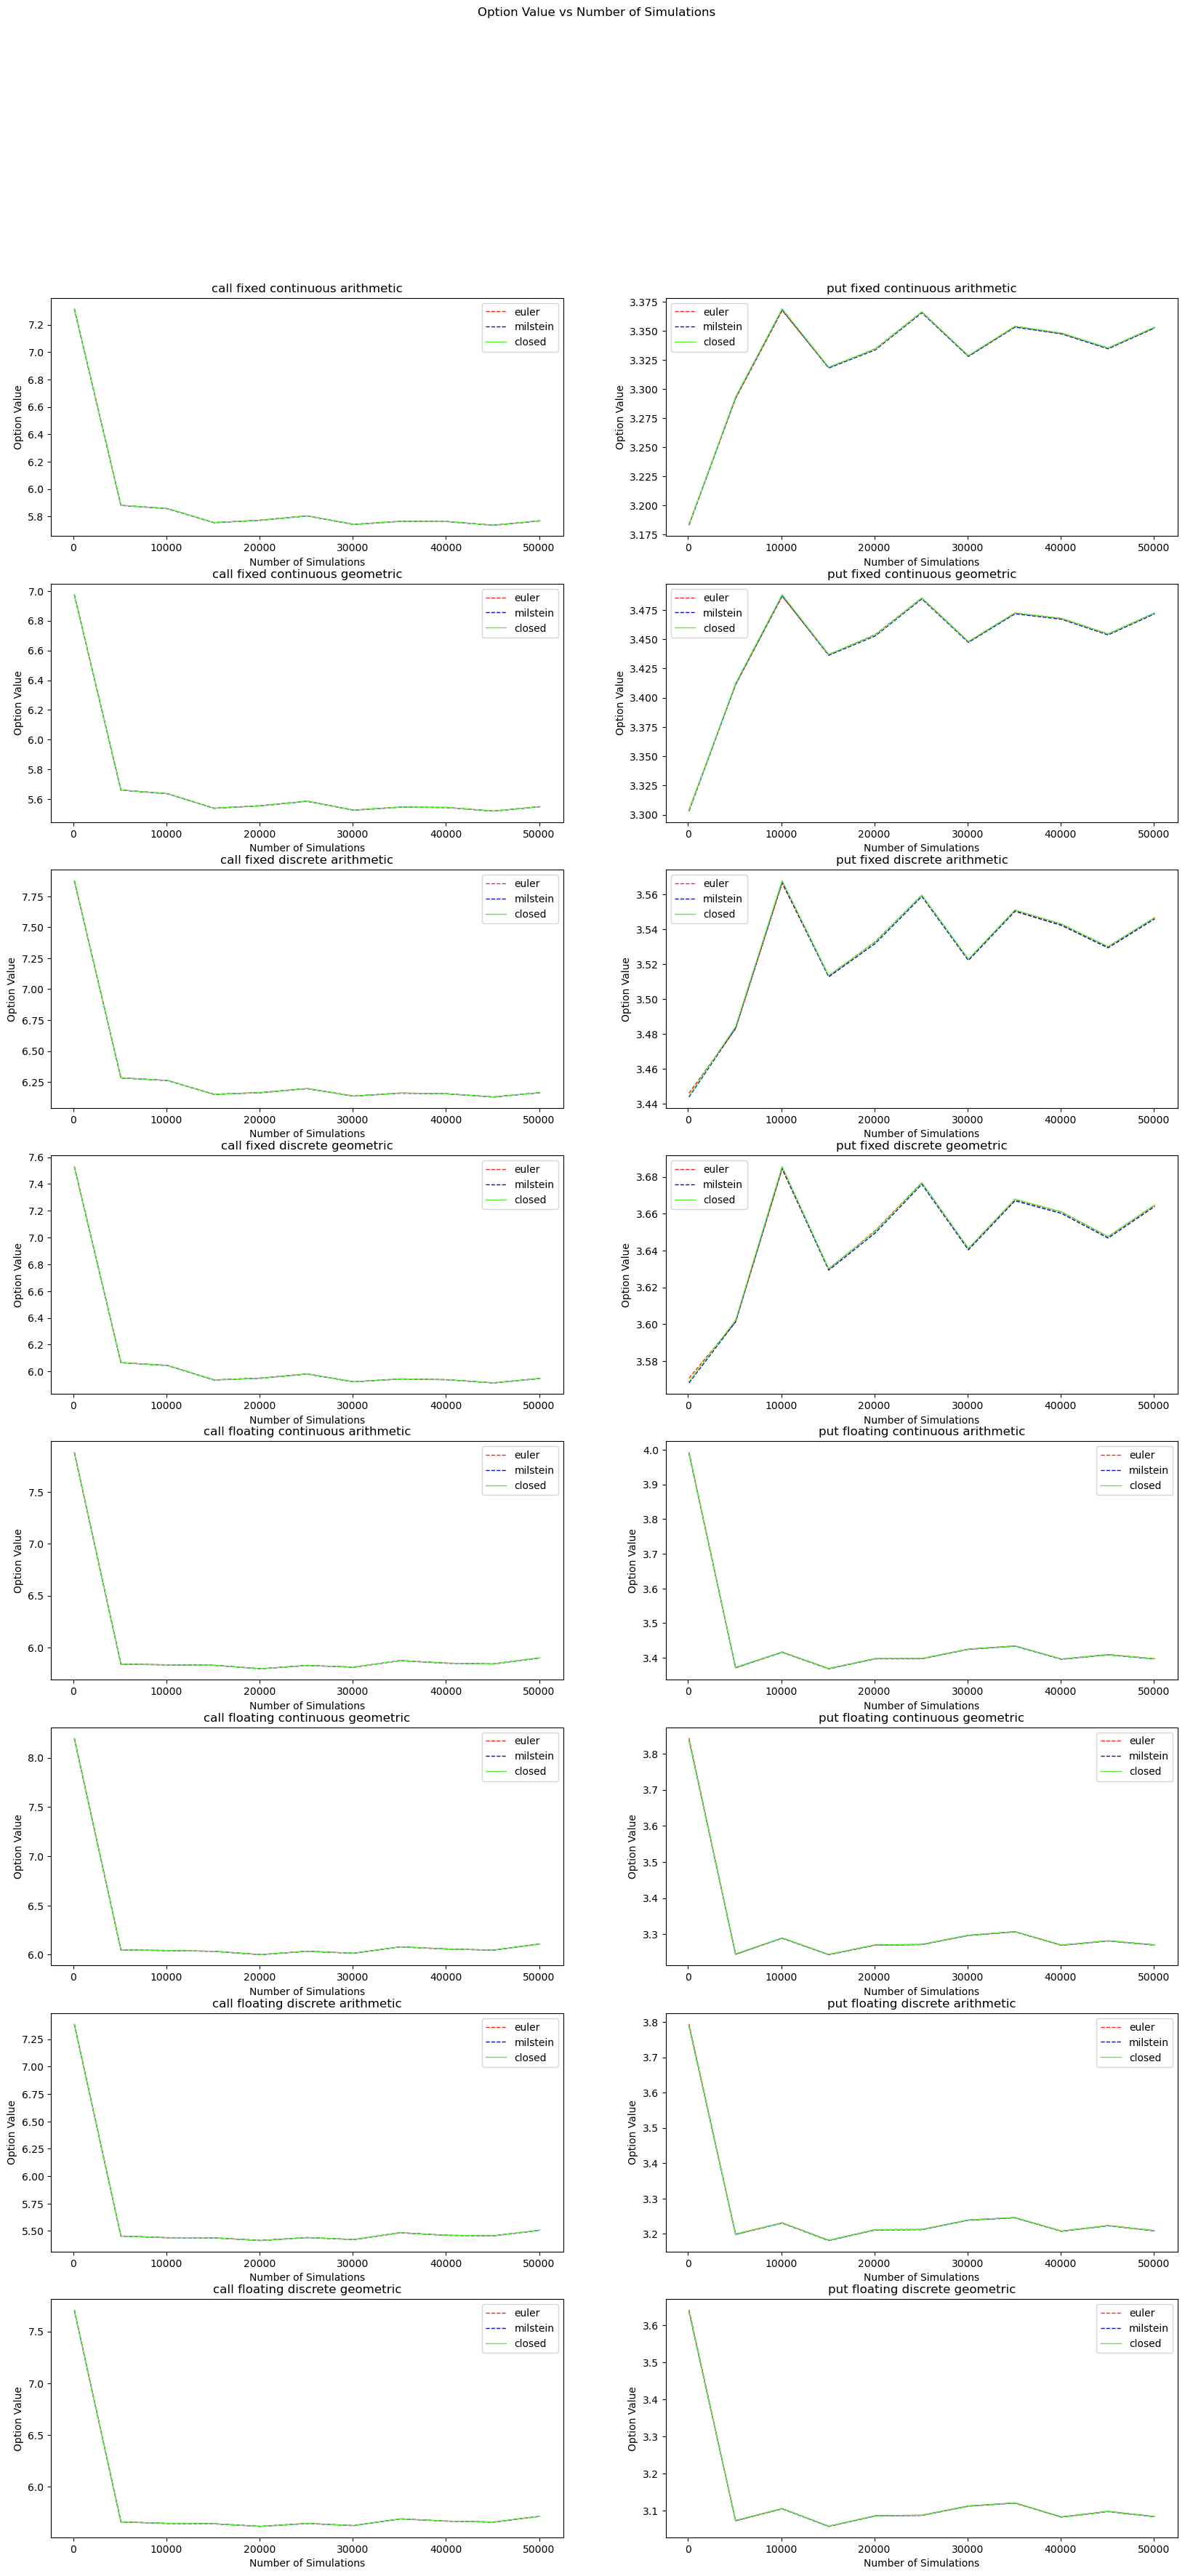

In [1077]:
asian_plot(s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,strike=100)

The above plots are all very similar to each other. All of the plots start off at a relatively high/low option value, but then as the number of simulations increases, the option value would decrease/increase (respectively) and then oscillates around a certain level. This 'certain' level is the 'true' value of the option (assuming the assumptions used are appropriate). Hence, we need a sufficiently large number of simulations in order for the calculated option value to be sufficiently accurate.

Now let's take a closer look at the option value generated by the closed-form, EM, and Milstein scheme.

In [1078]:
def summary_asian(s0,mu,sigma,horizon,timesteps,n_sims, option_type,strike_type,
                  sampling_type, average_type,strike):
    # Create an empty array
    arr_large_nsims = np.zeros((3,3))
    
    for i in range(3):
        seed = np.random.randint(1,1000)
        # EM
        em_call_fix_cont_art = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=n_sims,
                                                  sim_type="euler", option_type=option_type,strike_type=strike_type,
                                                  sampling_type=sampling_type, average_type=average_type,strike=strike,seed=seed)
        arr_large_nsims[i,0] = em_call_fix_cont_art

        # Milstein
        mil_call_fix_cont_art = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=n_sims,
                                              sim_type="milstein", option_type=option_type,strike_type=strike_type,
                                              sampling_type=sampling_type, average_type=average_type,strike=strike,seed=seed)
        arr_large_nsims[i,1] = mil_call_fix_cont_art

        # Closed form
        closed_call_fix_cont_art = monte_carlo_asian(s0=s0,mu=mu,sigma=sigma,horizon=horizon,timesteps=timesteps,n_sims=n_sims,
                                              sim_type="closed", option_type=option_type,strike_type=strike_type,
                                              sampling_type=sampling_type, average_type=average_type,strike=strike,seed=seed)
        arr_large_nsims[i,2] = closed_call_fix_cont_art
    
    df_large_nsims = pd.DataFrame(arr_large_nsims)
    df_large_nsims.columns = ["EM","Milstein","Closed-form"]
    df_large_nsims["abs(EM - Closed-form)"] = abs(df_large_nsims["EM"] - df_large_nsims["Closed-form"])
    df_large_nsims["abs(Milstein - Closed-form)"] = abs(df_large_nsims["Milstein"] - df_large_nsims["Closed-form"])
    
    return df_large_nsims

<b> call asian with fixed strike, continuous sampling, and arithmetic average </b>

In [1031]:
# Large number of simulations
summary_asian(s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=100000, option_type="call",
              strike_type="fixed",sampling_type="continuous", average_type="arithmetic",strike=100)

,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,5.757720,5.757241,5.758248,0.000528,0.001007
1,5.771932,5.771188,5.772201,0.000269,0.001013
2,5.741322,5.740623,5.741630,0.000308,0.001007


This table represents 3 sets of option values (call Asian option with fixed strike, continuous sampling, and arithmetic average) derived from 100,000 simulations using EM scheme, Milstein scheme, and closed-form solution (note that in each column of a row, the same sets of random numbers are used for the EM, Milstein and closed-form scheme). Then we also calculated the absolute difference between the option value derived from the EM scheme and closed-form solution; and the Milstein scheme and closed-form solution.

In [1032]:
# Small number of simulations
summary_asian(s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=100, option_type="call",
              strike_type="fixed",sampling_type="continuous", average_type="arithmetic",strike=100)

,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,6.293420,6.294398,6.295458,0.002038,0.001060
1,5.144952,5.123952,5.124664,0.020288,0.000712
2,6.422765,6.434696,6.435816,0.013052,0.001120


This table is similar to the one above, the only difference being the number of simulations which is 100 instead of 100,000.

From the two tables above, the interesting thing I find is that, compared to the option value calculated using the EM scheme, the option value derived from the Milstein scheme is always closer to the option value derived from the closed-form scheme when the number of simulations taken is small. However, if the number of simulations taken is large, it is the other way around, i.e. (compared to Milstein scheme) the option value derived from EM scheme is always closer to the option value derived from the closed-form scheme.

While the observation above is based on a call Asian option with fixed strike, continuous sampling, and arithmetic average, we also notice similar observations on other types of Asian options (call/put Asian options with fixed/floating strike; discrete/continuous sampling; arithmetic/geometric averaging). The tables for the other types of Asian options are provided in the appendix.

I find this result to be counterintuitive. Since Milstein scheme is a better approximator than the EM scheme, I would expect the option value derived from the Milstein scheme to always be the one that is closer to the option value derived from the closed-form solution, regardless of the number of simulations.

## Part 3 (Sensitivity of Option Price)

In [1092]:
# defining the sensitivity function
def sensitivity(variable,lower_bound,upper_bound,step_size,s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=1000,strike=100):
    '''
    variable -> "s0","mu","sigma","horizon"
    '''
    variable_range = np.arange(lower_bound, upper_bound+step_size, step_size)

    # Create a dictionary with key-value pairs that correspond to the type of Asian option and the variable
    dic = {}
    for option_type in ["call","put"]:
        for strike_type in ["fixed","floating"]:
            for sampling_type in ["continuous","discrete"]:
                for average_type in ["arithmetic","geometric"]:
                    df_sensitivity = pd.DataFrame(np.zeros((len(variable_range),3)))
                    df_sensitivity.columns = ["euler","milstein","closed"]
                    df_sensitivity.index = variable_range
                    dic[option_type+" "+strike_type+" "+sampling_type+" "+average_type] = df_sensitivity
                    for sim_type in ["euler","milstein","closed"]:
                        for x in variable_range:
                            if variable == "s0":
                                p = monte_carlo_asian(s0=x, mu=mu, sigma=sigma, horizon=horizon, timesteps=timesteps, n_sims=n_sims,
                                                      sim_type=sim_type, option_type=option_type, strike_type=strike_type,
                                                      sampling_type=sampling_type, average_type=average_type, strike=strike)
                                dic[option_type+" "+strike_type+" "+sampling_type+" "+average_type].loc[x,sim_type] = p
                            elif variable == "mu":
                                p = monte_carlo_asian(s0=s0, mu=x, sigma=sigma, horizon=horizon, timesteps=timesteps, n_sims=n_sims,
                                                      sim_type=sim_type, option_type=option_type, strike_type=strike_type,
                                                      sampling_type=sampling_type, average_type=average_type, strike=strike)
                                dic[option_type+" "+strike_type+" "+sampling_type+" "+average_type].loc[x,sim_type] = p
                            elif variable == "sigma":
                                p = monte_carlo_asian(s0=s0, mu=mu, sigma=x, horizon=horizon, timesteps=timesteps, n_sims=n_sims,
                                                      sim_type=sim_type, option_type=option_type, strike_type=strike_type,
                                                      sampling_type=sampling_type, average_type=average_type, strike=strike)
                                dic[option_type+" "+strike_type+" "+sampling_type+" "+average_type].loc[x,sim_type] = p
                            elif variable == "horizon":
                                p = monte_carlo_asian(s0=s0, mu=mu, sigma=sigma, horizon=x, timesteps=timesteps, n_sims=n_sims,
                                                      sim_type=sim_type, option_type=option_type, strike_type=strike_type,
                                                      sampling_type=sampling_type, average_type=average_type, strike=strike)
                                dic[option_type+" "+strike_type+" "+sampling_type+" "+average_type].loc[x,sim_type] = p
                            else:
                                print("INVALID VARIABLE")
    return dic

In [1093]:
# defining the function to plot the option price vs variable
def plot_sensitivity(dictionary_input, xlabel):
    fig, ax = plt.subplots(8,2,figsize=(20,40))

    j = 0 #index for the column of subplots
    for option_type in ["call","put"]:
        i = 0 #index for the row of subplots
        for strike_type in ["fixed","floating"]:
            for sampling_type in ["continuous","discrete"]:
                for average_type in ["arithmetic","geometric"]:
                    y = 0 #index for plot style
                    for sim_type in ["euler","milstein","closed"]:
                        color = ["#fc2412","#090cba","#5feb3f"]
                        ls = ['--','--','-']
                        label = ["EM","Milstein","Closed-form"]
                        ax[i,j].plot(dictionary_input[option_type+" "+strike_type+" "+sampling_type+" "+average_type].loc[:,sim_type], label=label[y], color=color[y],ls=ls[y],linewidth = '1')
                        ax[i,j].legend()
                        ax[i,j].set_xlabel(xlabel)
                        ax[i,j].set_ylabel("Option Value")
                        y = y + 1
                    ax[i,j].set_title(option_type+" "+strike_type+" "+sampling_type+" "+average_type+" "+sim_type)
                    i = i + 1
        j = j + 1
    plt.show()

#### Sensitivity to today's stock price (Delta)

In [1094]:
# option price vs stock price
dic_delta = sensitivity(variable="s0",lower_bound=0.001,upper_bound=160,step_size=2,s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=100,strike=100)

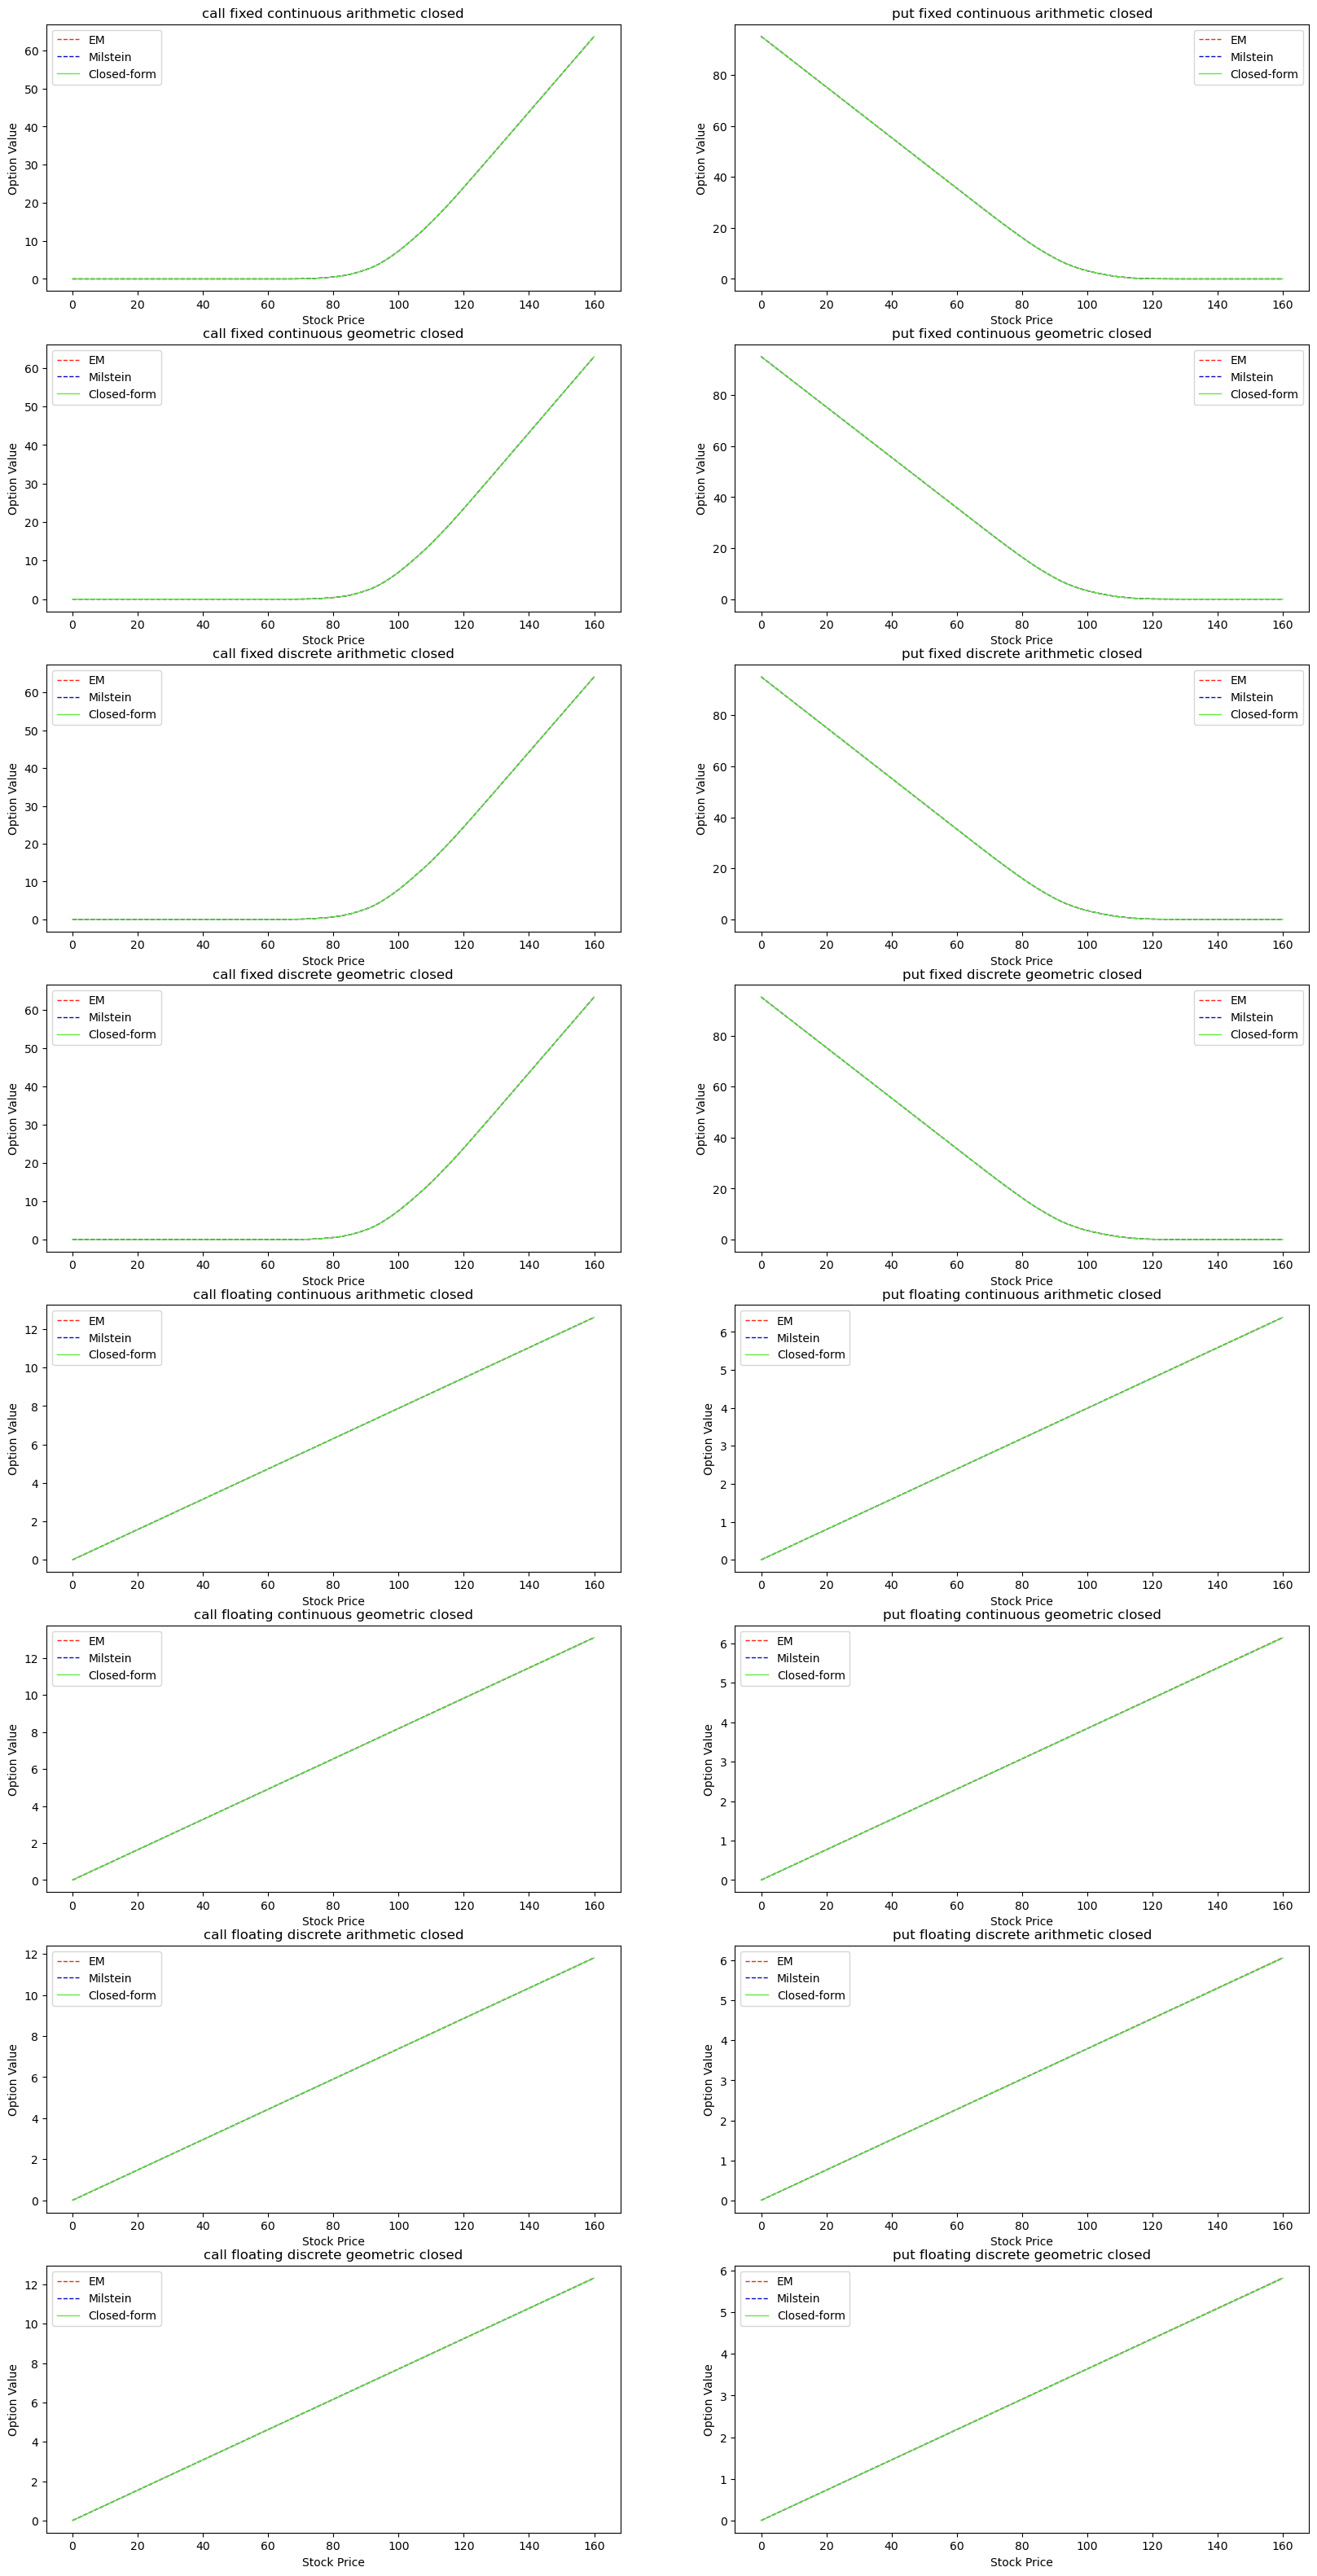

In [1095]:
# Plot option price vs stock price
plot_sensitivity(dictionary_input=dic_delta, xlabel="Stock Price")

If we compute the gradient of the plot above, we would get the option delta. Delta is the sensitivity of option value to the change in underlying price. Moreover, if we continue to take the gradient of the gradient, i.e. second order derivative with respect to the underlying price, we would obtain the option gamma.

Notice that from the plot above, Asian call and put options with floating strike price seem to form a straight line with a positive slope, i.e. constant positive delta (and hence gamma is zero). In contrast, Asian options with fixed strike price form a curve with a gradient/delta that is always positive (negative) in the case of call (put) Asian options. Additionally, notice that the gamma of these fixed strike price Asian options is always positive.

We can take the conclusion that the value of a call (put) Asian option with fixed strike would increase (decrease) as the current stock price increases. Additionally, Asian options with a floating strike (regardless if it is a call or a put) will increase in value as the current stock price increases.

(Note that the option values derived from closed-form, EM, and Milstein scheme seem to be very much identical in the plots above. However, they are not perfectly identical. There are small differences between those option values, but are not visible in the plots above.)

#### Sensitivity to volatility (Vega)

In [1097]:
# option price vs volatility
dic_vega = sensitivity(variable="sigma",lower_bound=0.0,upper_bound=0.3,step_size=0.01,s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=1000,strike=100)

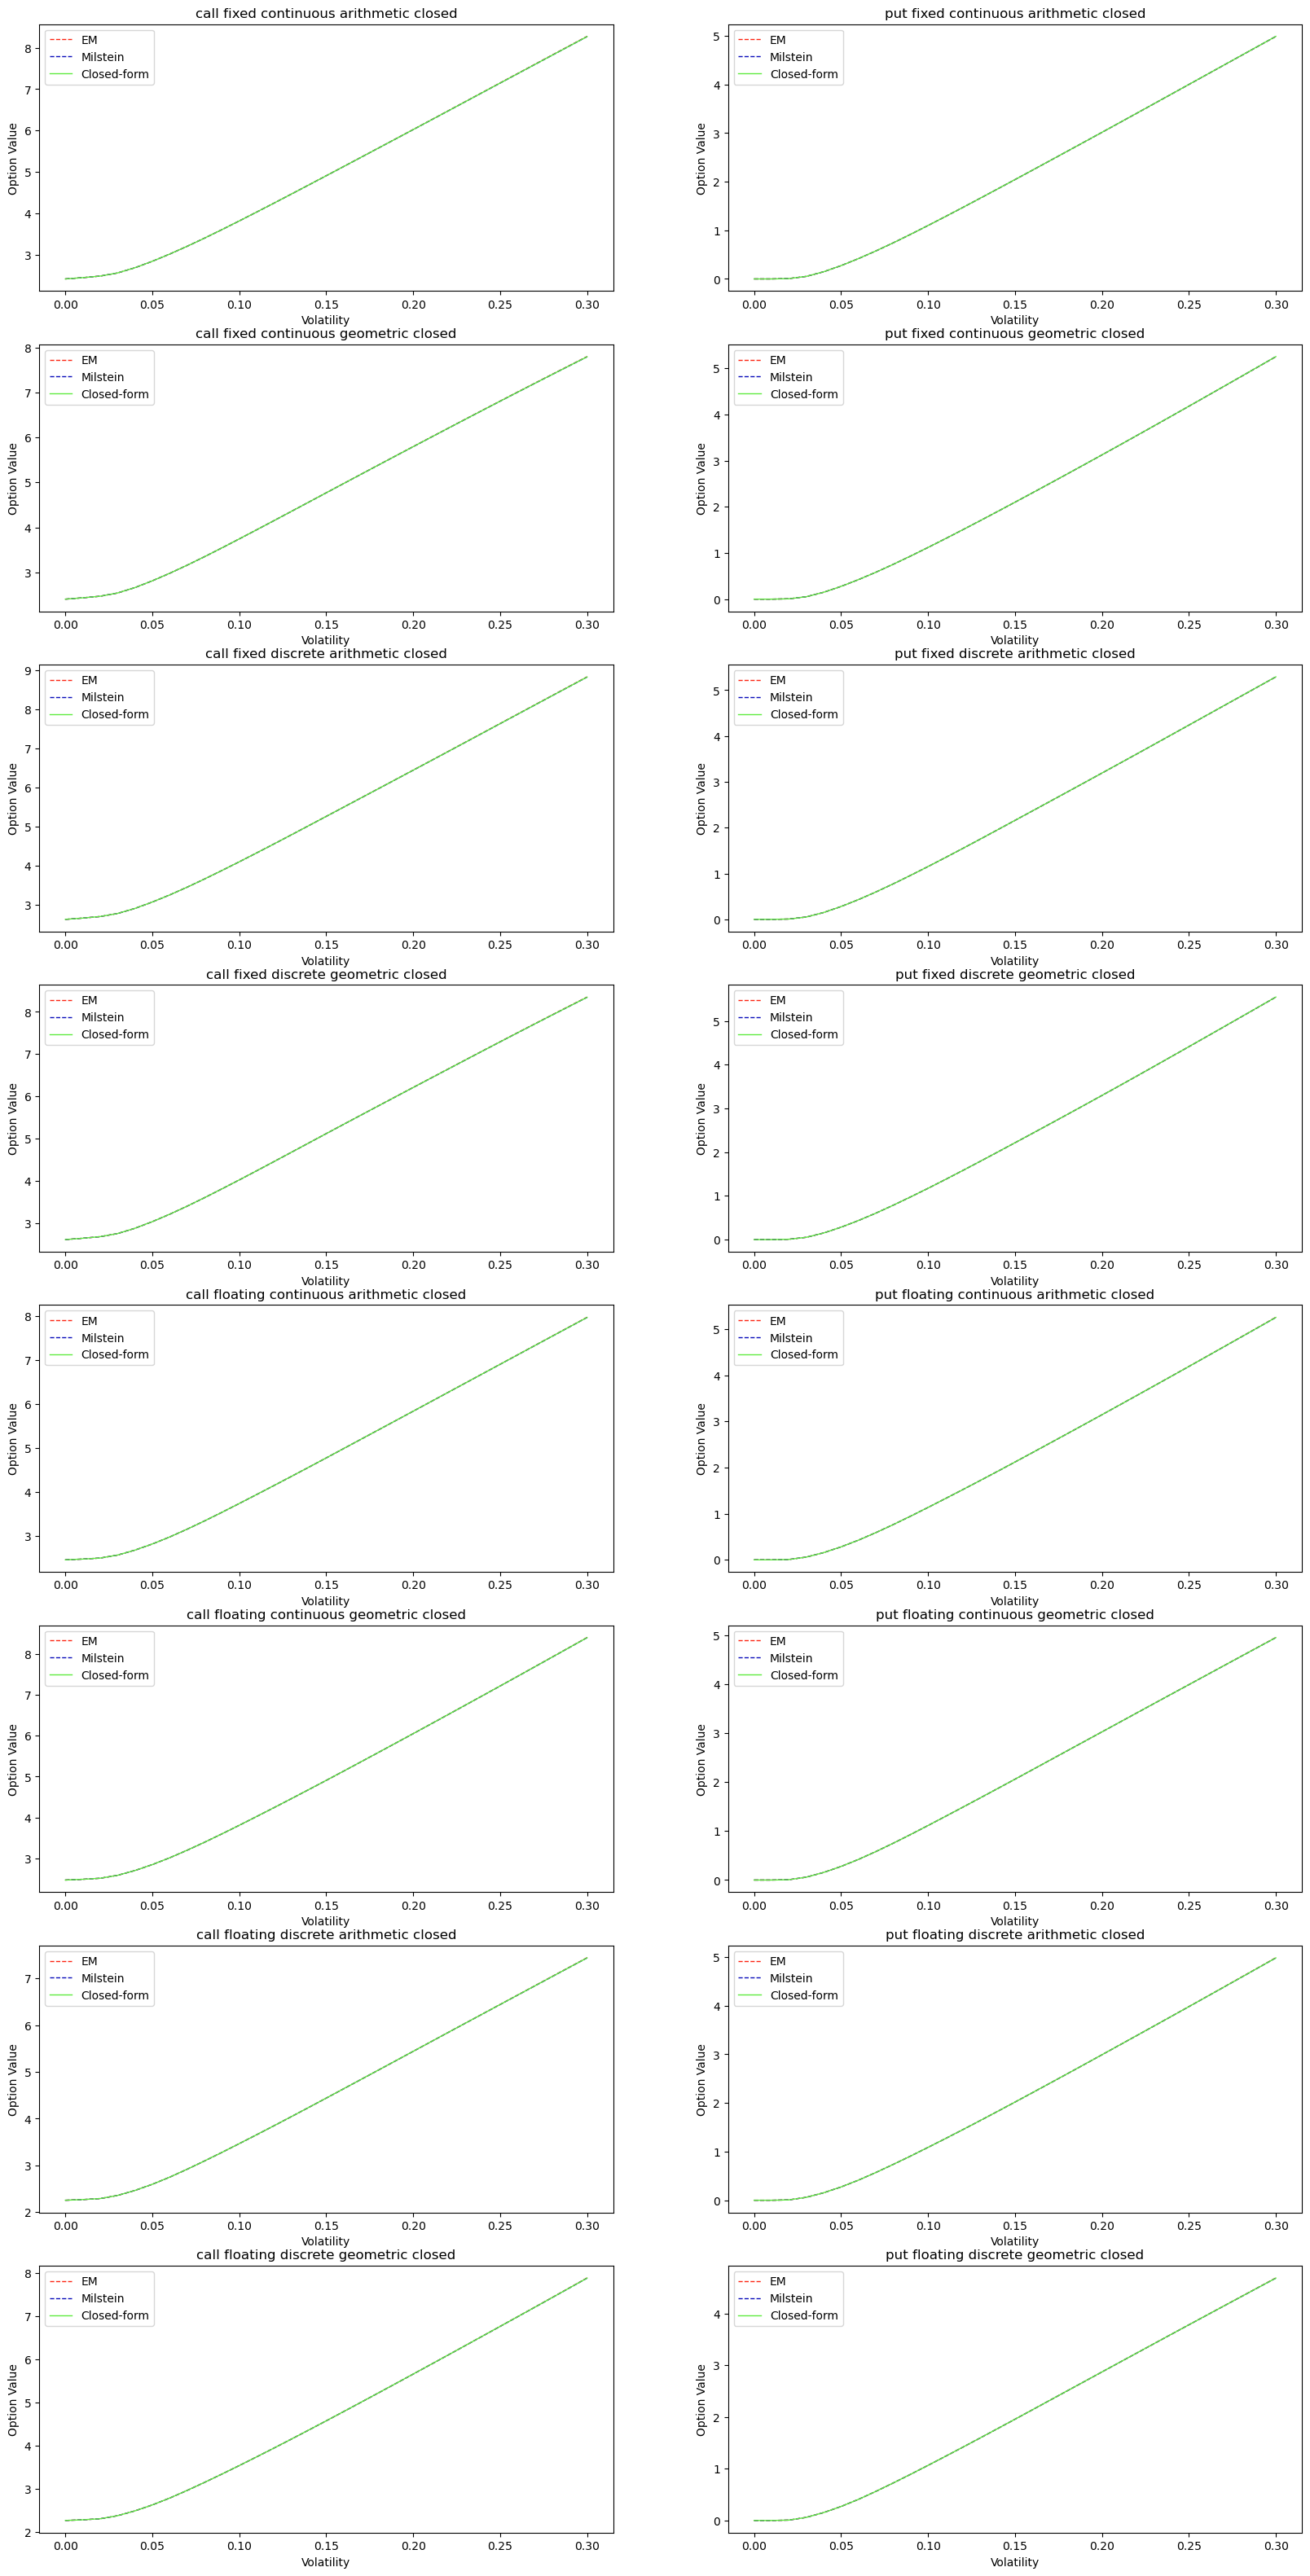

In [1098]:
# Plot option price vs volatility
plot_sensitivity(dictionary_input=dic_vega, xlabel="Volatility")

If we compute the gradient for the plots above, we would obtain the option vega, which is the sensitivity of the option value to the change in volatility.

Notice that all of the curves from the plots above have a slope/vega that is always positive. To be more detailed, vega is initially very small (when volatility is small) but then the vega increases as volatility increases until eventually, the vega becomes constant.

Since vega is always positive, this means that the option value would increase as volatility increases, vice versa.

(Note that the option values derived from closed-form, EM, and Milstein scheme seem to be very much identical in the plots above. However, they are not perfectly identical. There are small differences between those option values, but are not visible in the plots above.)

#### Sensitivity to interest rate (Rho)

In [1099]:
# option price vs interest rate
dic_rho = sensitivity(variable="mu",lower_bound=0.001,upper_bound=0.3,step_size=0.002,s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=1000,strike=100)

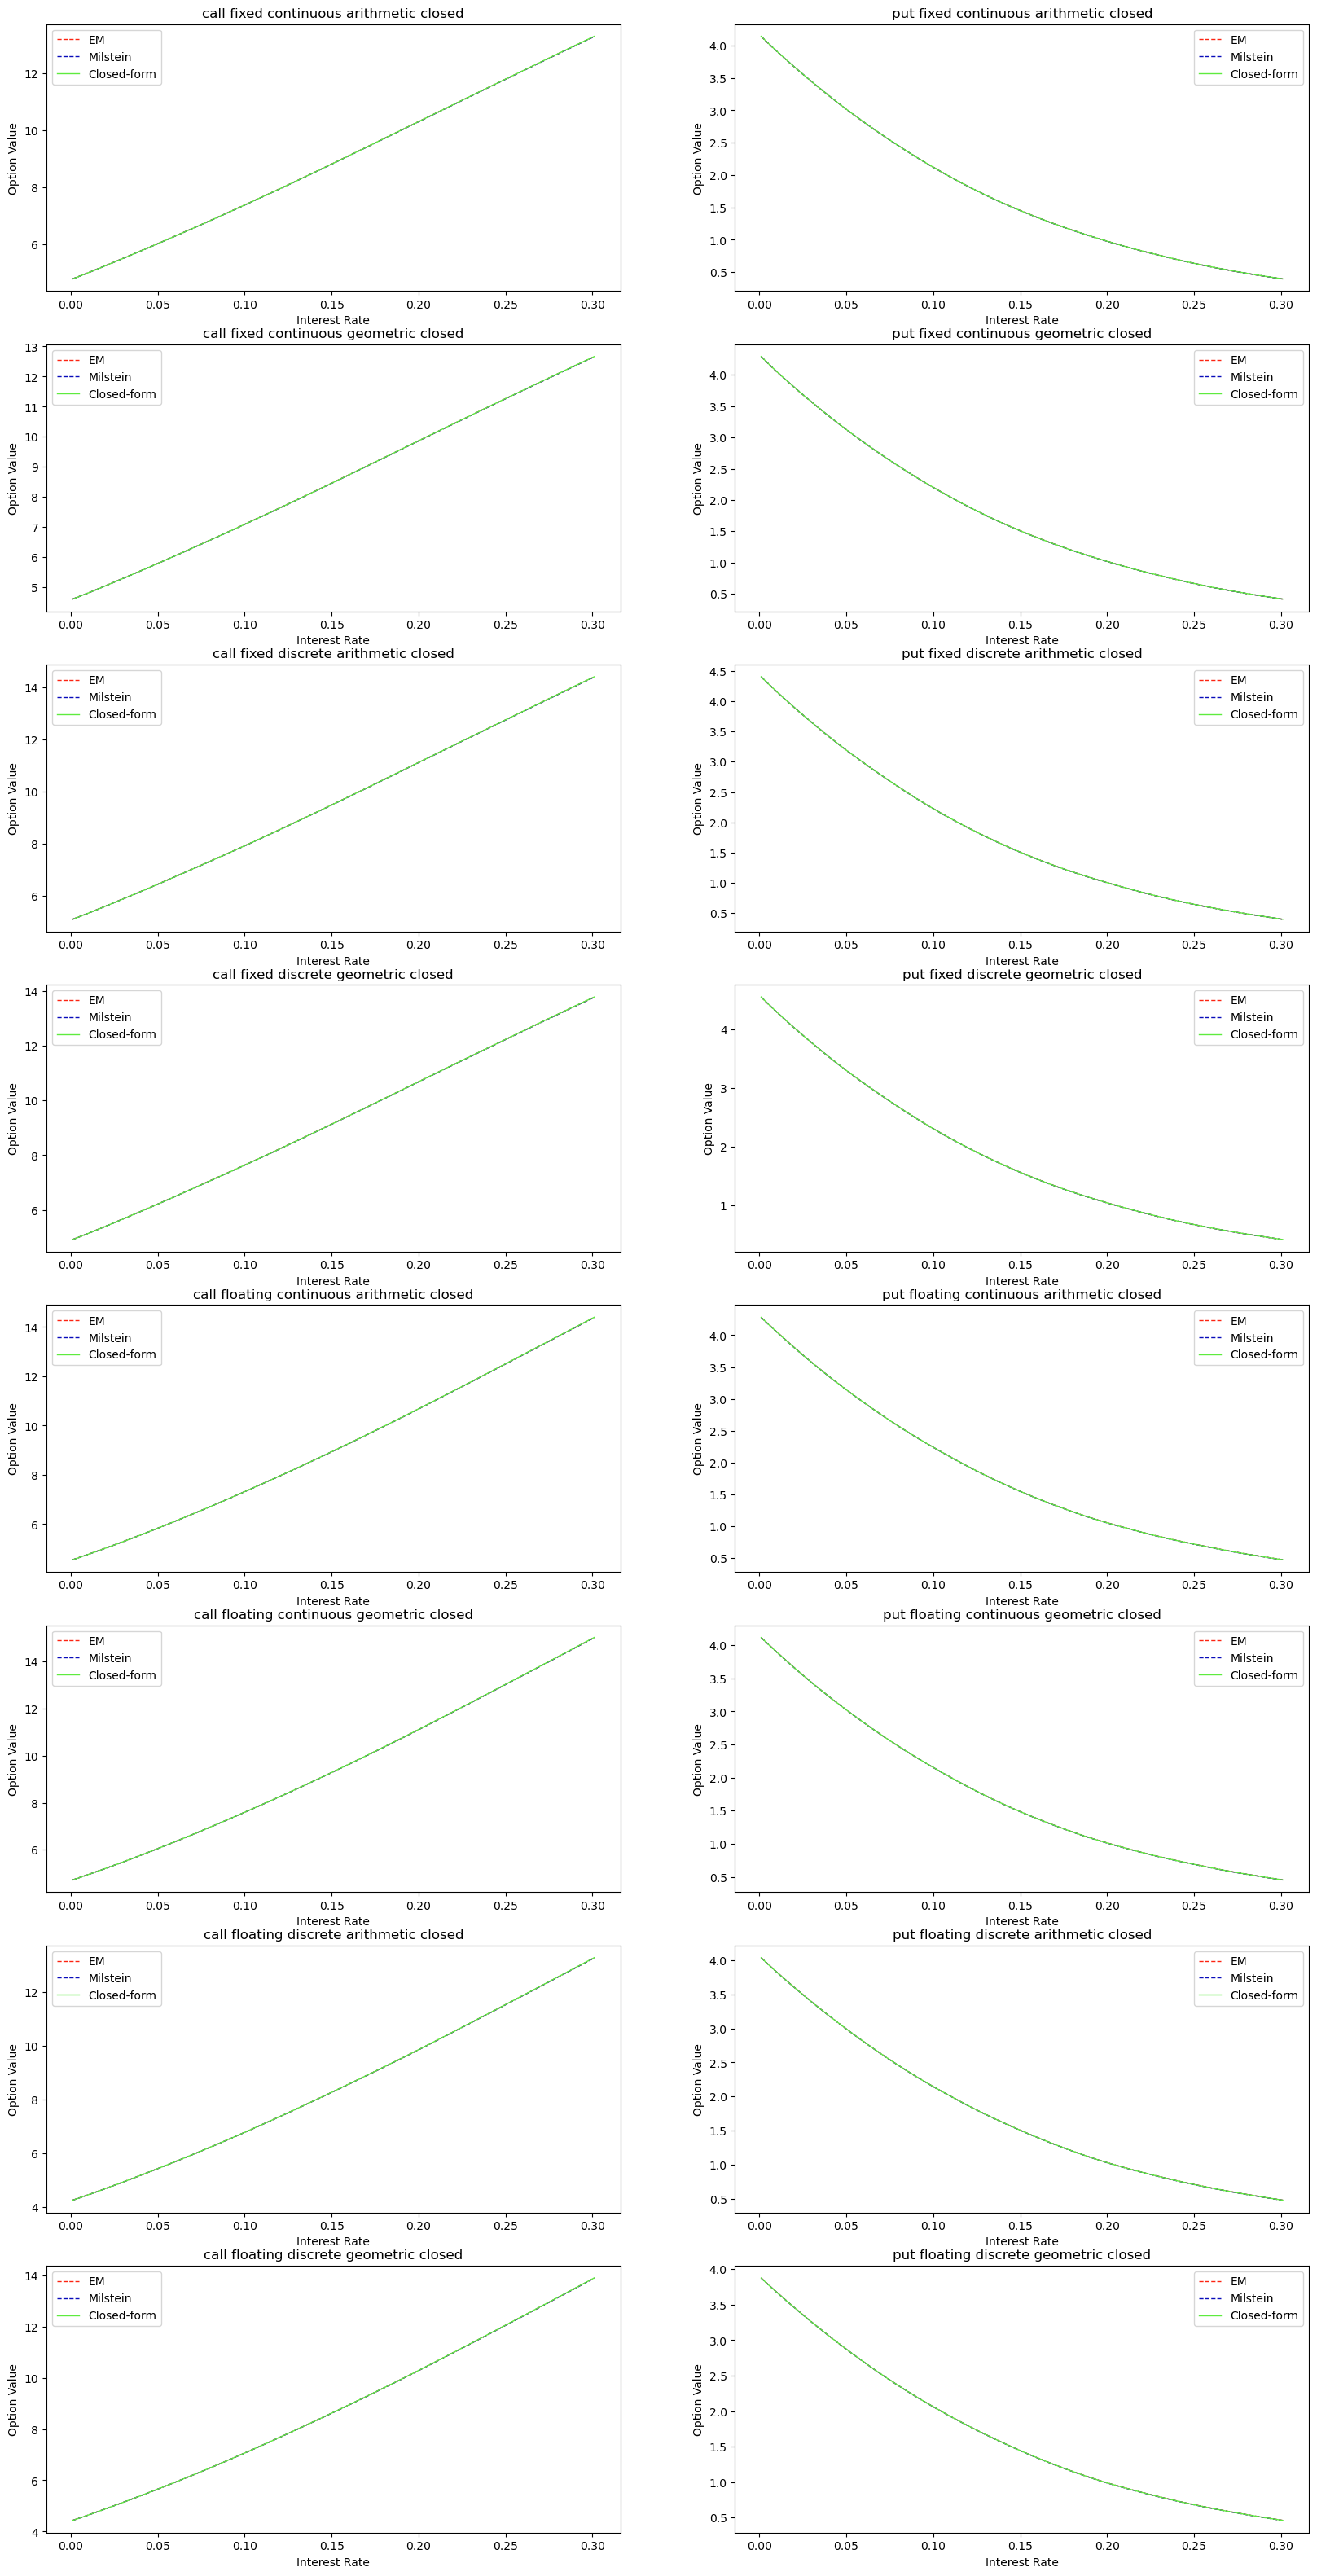

In [1100]:
# Plot option price vs interest rate
plot_sensitivity(dictionary_input=dic_rho, xlabel="Interest Rate")

If we compute the gradient for the plots above, we would obtain the option rho, which is the sensitivity of the option value to the change in interest rate.

Notice that call Asian options seem to show an upward-sloping curve, which means that the value of the option increases as interest rate increases. In contrast, put Asian options seem to show a downward-sloping curve, which means that the value of the option decreases as interest rate increases.

(Note that the option values derived from closed-form, EM, and Milstein scheme seem to be very much identical in the plots above. However, they are not perfectly identical. There are small differences between those option values, but are not visible in the plots above.)

#### Sensitivity to time-to-maturity (Theta)

In [1101]:
# option price vs maturity
dic_theta = sensitivity(variable="horizon",lower_bound=0.5,upper_bound=3,step_size=0.01,s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=1000,strike=100)

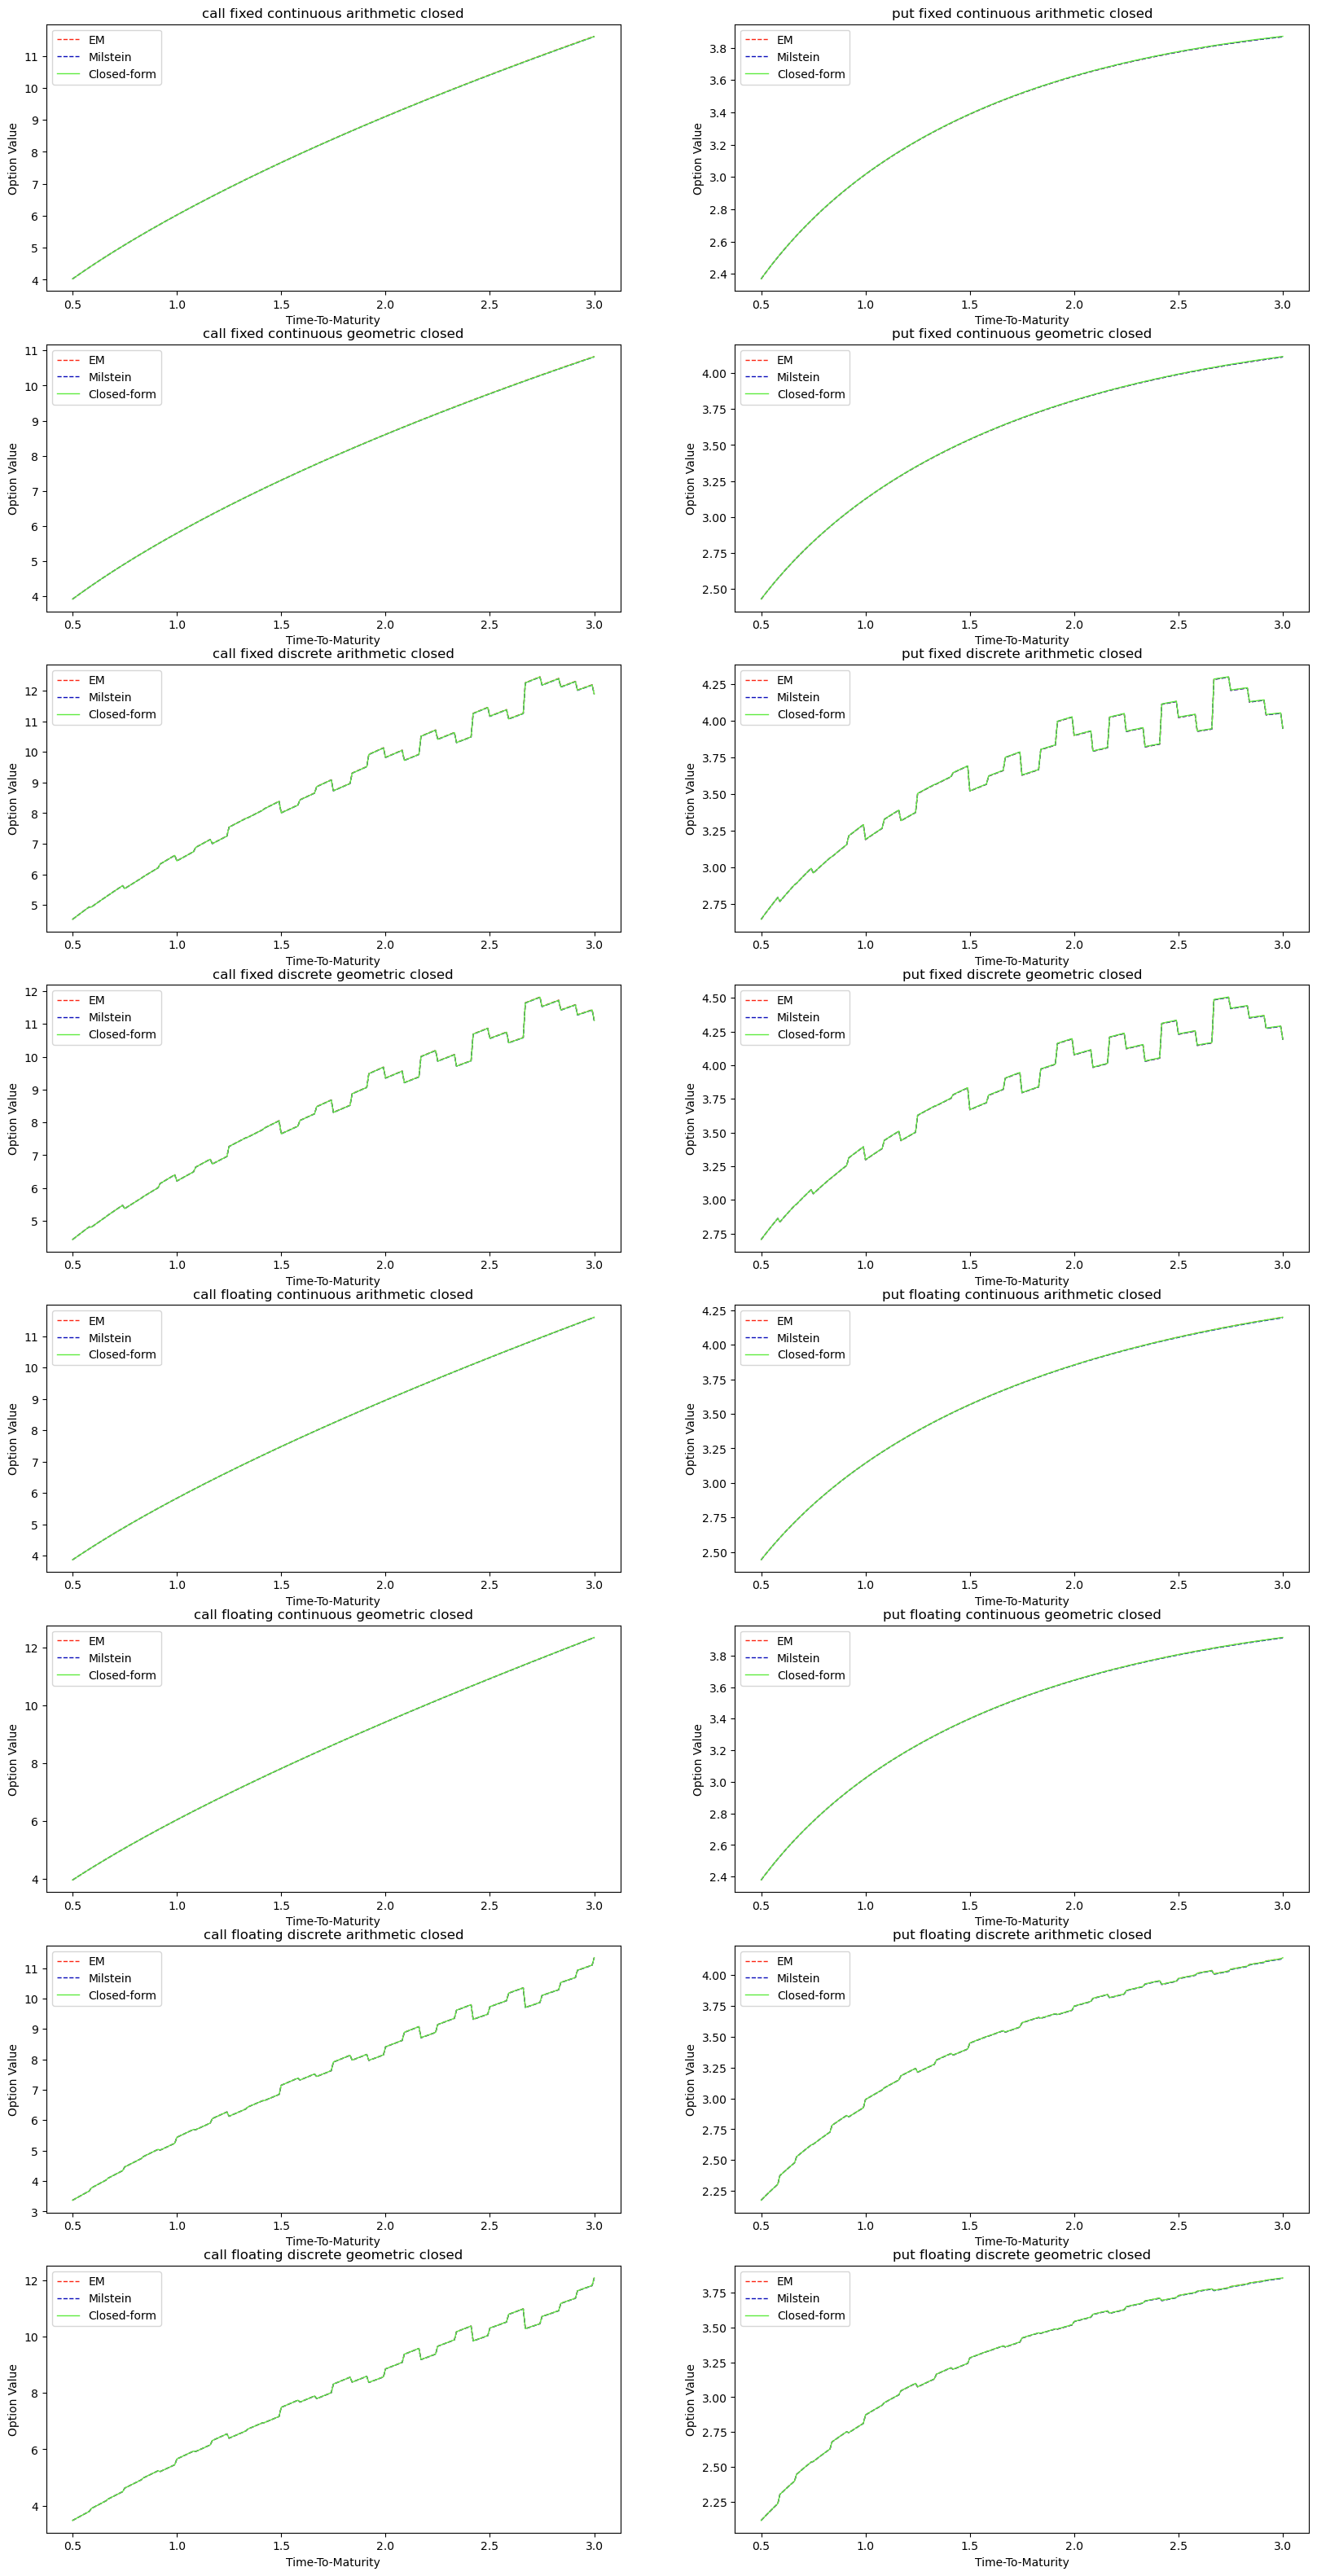

In [1102]:
# Plot option price vs Maturity
plot_sensitivity(dictionary_input=dic_theta, xlabel="Time-To-Maturity")

If we compute the gradient for the plots above, we would obtain the option theta, which is the sensitivity of the option price to the change in time-to-maturity.

From all of the plots above, we can generally conclude that option value is higher for options with longer maturity, since all of the plots above are generally upward sloping.

The interesting thing to note from the plot above is that if the option is continuously sampled, the option value vs time-to-maturity plot is a smooth curve. However, if the option is discretely sampled, the plot is very jagged. This is due to the fact that in the pricing algorithm, I made the assumption that the samples for the discretely sampled Asian options are taken once every month, with the last sample always taken at maturity.

(Note that the option values derived from closed-form, EM, and Milstein scheme seem to be very much identical in the plots above. However, they are not perfectly identical. There are small differences between those option values, but are not visible in the plots above.)

## Conclusion
From part 1, we showed that Milstein scheme is a more accurate approximator to the closed-form solution, compared to the EM scheme. Then we also observed that the larger the time-step size and volatility, the greater the approximation error will be.

Moving on to part 2, we concluded that in order to get a more accurate option value, we need to increase the number of simulations. Moreover, we saw an interesting observation that, if the number of simulations taken is small, the option value derived from Milstein scheme is the one that is closer to the option value derived from the closed-form scheme. Meanwhile, if the number of simulations taken is large, the option value derived from EM scheme is the one that is closer to the option value derived from the closed-form scheme.

From part 3, we showed that the value of a call (put) Asian option with fixed strike would increase (decrease) as the current stock price increases. On the other hand, Asian options with a floating strike will increase in value as the current stock price increases. Additionally, we learned that the higher the volatility and the longer the time-to-maturity, the higher the value of the Asian option (any type of Asian option). Lastly, the value of a call (put) Asian option would increase (decrease) as the interest rate increases.

# Appendix (Related to Part 2)

In order to prevent clustering of information, I am only going show some of the other types of Asian option:

In [1082]:
def app_asian(n_sims, strike_type,sampling_type,average_type):
    # Large number of simulations
    c_1_l = summary_asian(s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=n_sims, option_type="call",
                  strike_type=strike_type,sampling_type=sampling_type, average_type=average_type,strike=100)
    print("Call Asian with", strike_type, "strike,", sampling_type, "sampling, and", average_type, "average")
    display(c_1_l)

    # Large number of simulations
    p_1_l = summary_asian(s0=100,mu=0.05,sigma=0.2,horizon=1,timesteps=252,n_sims=n_sims, option_type="put",
                  strike_type="floating",sampling_type="continuous", average_type="arithmetic",strike=100)
    print("Put Asian with", strike_type, "strike,", sampling_type, "sampling, and", average_type, "average")
    display(p_1_l)

<b> Asian with floating strike, continuous sampling, and arithmetic average </b>

In [1084]:
# Large number of simulations
print("Large number of simulations:")
app_asian(n_sims=100000, strike_type="floating",sampling_type="continuous",average_type="arithmetic")

Large number of simulations:
Call Asian with floating strike, continuous sampling, and arithmetic average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,5.838470,5.837929,5.838962,0.000492,0.001033
1,5.804544,5.803574,5.804598,0.000054,0.001025
2,5.885578,5.883987,5.885030,0.000549,0.001043


Put Asian with floating strike, continuous sampling, and arithmetic average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,3.405820,3.405069,3.405856,0.000036,0.000787
1,3.413216,3.412333,3.413121,0.000096,0.000788
2,3.403602,3.402819,3.403604,0.000001,0.000784


In [1085]:
# small number of simulations
print("Small number of simulations:")
app_asian(n_sims=100, strike_type="floating",sampling_type="continuous",average_type="arithmetic")

Small number of simulations:
Call Asian with floating strike, continuous sampling, and arithmetic average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,5.849464,5.841970,5.843016,0.006448,0.001046
1,6.640840,6.636689,6.637867,0.002973,0.001178
2,4.285296,4.297604,4.298323,0.013027,0.000719


Put Asian with floating strike, continuous sampling, and arithmetic average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,3.380975,3.379099,3.379848,0.001127,0.000749
1,3.974646,3.969813,3.970655,0.003992,0.000842
2,3.019083,3.022930,3.023616,0.004533,0.000687


<b> Asian with fixed strike, discrete sampling, and geometric average </b>

In [1088]:
# Large number of simulations
print("Large number of simulations:")
app_asian(n_sims=100000, strike_type="fixed",sampling_type="discrete",average_type="geometric")

Large number of simulations:
Call Asian with fixed strike, discrete sampling, and geometric average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,5.963830,5.962476,5.963478,0.000352,0.001002
1,5.970133,5.968919,5.969919,0.000214,0.001000
2,5.956635,5.955710,5.956711,0.000076,0.001001


Put Asian with fixed strike, discrete sampling, and geometric average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,3.413216,3.412333,3.413121,0.000096,0.000788
1,3.403602,3.402819,3.403604,0.000001,0.000784
2,3.411185,3.410119,3.410908,0.000277,0.000789


In [1091]:
# small number of simulations
print("Small number of simulations:")
app_asian(n_sims=100, strike_type="fixed",sampling_type="discrete",average_type="geometric")

Small number of simulations:
Call Asian with fixed strike, discrete sampling, and geometric average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,8.487841,8.489303,8.490739,0.002898,0.001436
1,5.878719,5.905192,5.906235,0.027516,0.001043
2,5.332416,5.334691,5.335521,0.003105,0.000829


Put Asian with fixed strike, discrete sampling, and geometric average


,EM,Milstein,Closed-form,abs(EM - Closed-form),abs(Milstein - Closed-form)
0,4.570755,4.561516,4.562458,0.008297,0.000943
1,3.082775,3.090099,3.090822,0.008047,0.000724
2,3.838773,3.833945,3.834806,0.003967,0.000861


Consistent with what was mentioned before, the option value derived from Milstein scheme is always closer to the option value derived from the closed-form solution when the number of simulations taken is small. In contrast, when the number of simulations takes is large, the option value derived from EM scheme is always closer to the option value derived from the closed-form scheme.